# Cox time-varying proportional hazards model with hyperparameter tuning

In [1]:
import sys
import logging
from pathlib import Path
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

from hyperopt import hp
import pandas as pd
from prefect import Flow, unmapped

from nbaspa.model.tasks import (
    SurvivalData,
    SegmentData,
    InitializeLifelines,
    FitLifelinesModel,
    CollapseData,
    PredictLifelines,
    WinProbability,
    PlotProbability,
    ConcordanceIndex,
    AUROC,
    PlotMetric,
    LifelinesTuning,
    PlotTuning
)
from nbaspa.model.tasks.meta import META

# Suppress the SettingWithCopyWarning for logging clarity
pd.options.mode.chained_assignment = None  # default='warn'

## Load the data

In [2]:
df = pd.concat(
    pd.read_csv(fpath, sep="|", dtype={"GAME_ID": str}, index_col=0)
    for fpath in Path("..", "nba-data", "2018-19", "model-data").glob("data_*.csv")
).reset_index(drop=True)

In [3]:
df[
    [META["id"], META["benchmark"]] + META["dynamic"] + META["static"]
].head(n=5)

,GAME_ID,NBA_WIN_PROB,SCOREMARGIN,HOME_LINEUP_PLUS_MINUS,VISITOR_LINEUP_PLUS_MINUS,HOME_NET_RATING,VISITOR_NET_RATING,HOME_W_PCT,VISITOR_W_PCT,LAST_GAME_WIN,HOME_GAMES_IN_LAST_3_DAYS,HOME_GAMES_IN_LAST_5_DAYS,HOME_GAMES_IN_LAST_7_DAYS,VISITOR_GAMES_IN_LAST_3_DAYS,VISITOR_GAMES_IN_LAST_5_DAYS,VISITOR_GAMES_IN_LAST_7_DAYS
0,0021800001,0.58808,0,0.2,2.7,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
1,0021800001,0.61309,0,0.2,2.7,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
2,0021800001,0.61255,0,0.2,2.7,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
3,0021800001,0.58705,0,0.2,2.7,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0
4,0021800001,0.61240,0,0.2,2.7,5.1,3.3,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0


## Build the model with hyperparameter tuning

We'll use a $Unif(0, 1)$ distribution for both the `penalizer` and the `l1_ratio`. We will tune the model with 100 ``hyperopt`` iterations.

In [4]:
# Initial formatting and segmentation
format_data = SurvivalData(name="Convert input data to range form")
segdata = SegmentData(name="Split data")
# Collapsing data
tune_data = CollapseData(name="Create tuning data")
test_benchmark = CollapseData(name="Create final test data")
test_data = CollapseData(name="Create metric test data")
# Model tuning
tuning = LifelinesTuning(name="Hyperparameter tuning")
tuning_plots = PlotTuning(name="Hyperparameter plotting")
# Model training
model = InitializeLifelines(name="Initialize Cox model")
trained = FitLifelinesModel(name="Fit Cox model")
# Get model concordance
hazpred = PredictLifelines(name="Predict partial hazard function")
concord = ConcordanceIndex(name="Calculate Concordance index")
# Predict win probability and get AUROC
survpredict = WinProbability(name="Predict win probability")
predict = WinProbability(name="Predict win probability")
benchmark_prob = WinProbability(name="Get benchmark win probability")
auroc = AUROC(name="Calculate model AUROC")
aurocb = AUROC(name="Calculate benchmark AUROC")
metricplot = PlotMetric(name="Plot Concordance")
# Plot probability
probplot = PlotProbability(name="Plot the survival probability")

times = [0, 360, 720, 1080, 1440, 1800, 2160, 2520, 2880]

In [5]:
with Flow(name="My model pipeline") as flow:
    # Format and segment the data into train, tune, test
    alldata = format_data(df)
    data = segdata(alldata, splits=[0.6, 0.25], keys=["train", "tune", "test"])
    # Collapse the test and tune data to the final row so we can accurately calculate Concordance
    tune = tune_data(data["tune"])
    test_lr = test_benchmark(data["test"])
    # Create test data for time steps at the start of the game, end of 1st, etc.
    test = test_data.map(data=unmapped(data["test"]), timestep=times)
    # Hyperparameter tuning (with plots)
    params = tuning(data["train"], tune)
    tuning = tuning_plots(params["trials"])
    # Fit the final model from hyperparameter tuning
    model_obj = model(params["best"])
    fitted = trained(model=model_obj, data=data["train"])
    # Get the final Concordance index
    predt = hazpred(model=fitted, data=test_lr)
    cind = concord(data=test_lr, predt=predt)
    # Predict the survival probability at start of game, end of 1st, etc.
    surv = predict.map(model=unmapped(fitted), data=test)
    benchmark = benchmark_prob.map(model=unmapped("nba"), data=test)
    # Get the AUROC based on survival probability for each time step and plot
    metric = auroc.map(data=surv)
    metric_bench = aurocb.map(data=benchmark, mode=unmapped("benchmark"))
    plots = metricplot(times=times, metric="AUROC", survival=metric, nba=metric_bench)
    # Plot the final survival probability against the margin of the game
    survpred = survpredict(model=fitted, data=test_lr)
    prob = probplot(data=survpred)

[2021-02-15 03:51:05+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'My model pipeline'
[2021-02-15 03:51:06+0000] INFO - prefect.TaskRunner | Task 'Convert input data to range form': Starting task run...
[2021-02-15 03:51:32+0000] INFO - prefect.TaskRunner | Task 'Convert input data to range form': Finished task run for task with final state: 'Success'
[2021-02-15 03:51:32+0000] INFO - prefect.TaskRunner | Task 'Split data': Starting task run...
[2021-02-15 03:51:32+0000] INFO - prefect.Split data | Setting the seed to 42
[2021-02-15 03:51:32+0000] INFO - prefect.Split data | Dataset ``train`` has 738 games with 87145 rows
[2021-02-15 03:51:32+0000] INFO - prefect.Split data | Dataset ``tune`` has 307 games with 36308 rows
[2021-02-15 03:51:32+0000] INFO - prefect.Split data | Dataset ``test`` has 185 games with 21874 rows
[2021-02-15 03:51:32+0000] INFO - prefect.TaskRunner | Task 'Split data': Finished task run for task with final state: 'Success'
[2021-02-15 03:51:32+0000

<lifelines.CoxTimeVaryingFitter: fitted with 87145 periods, 738 subjects, 425 events>
         event col = 'WIN'
         penalizer = 0.08403522584678981
number of subjects = 738
 number of periods = 87145
  number of events = 425
partial log-likelihood = -2577.86
  time fit was run = 2021-02-15 03:52:32 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
HOME_NET_RATING                0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
VISITOR_NET_RATING            -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_W_PCT                     0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
VISITOR_W_PCT                 -0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
LAST_GAME_WIN                  0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_GAMES_IN_LAST_3_DAYS     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_GAMES_IN_LAST_5_DAYS     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
HOME_GAMES_IN_LAST_7_DAYS     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_GAMES_IN_LAST_3_DAYS   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_GAMES_IN_LAST_5_DAYS   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_GAMES_IN_LAST_7_DAYS   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
SCOREMARGIN                    0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
HOME_LINEUP_PLUS_MINUS         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
VISITOR_LINEUP_PLUS_MINUS      0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                                 z      p   -log2(p)
covariate                                           
HOME_NET_RATING               0.47   0.64       0.64
VISITOR_NET_RATING           -0.05   0.96       0.06
HOME_W_PCT                    0.01   0.99       0.02
VISITOR_W_PCT                -0.02   0.99       0.02
LAST_GAME_WIN                 0.01   0.99       0.01
HOME_GAMES_IN_LAST_3_DAYS    -0.01   0.99       0.01
HOME_GAMES_IN_LAST_5_DAYS    -0.01   0.99       0.01
HOME_GAMES_IN_LAST_7_DAYS    -0.01   0.99       0.01
VISITOR_GAMES_IN_LAST_3_DAYS  0.00   1.00       0.01
VISITOR_GAMES_IN_LAST_5_DAYS  0.00   1.00       0.00
VISITOR_GAMES_IN_LAST_7_DAYS  0.01   1.00       0.01
SCOREMARGIN                   4.82 <0.005      19.42
HOME_LINEUP_PLUS_MINUS        0.01   1.00       0.01
VISITOR_LINEUP_PLUS_MINUS     0.00   1.00       0.01
---
Partial AIC = 5183.72
log-likelihood ratio test = 23.55 on 14 df
-log2(p) of ll-ratio test = 4.27

[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Fit Cox model': Finished task run for task with final state: 'Success'
[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Predict win probability': Starting task run...
[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Predict win probability': Finished task run for task with final state: 'Mapped'
[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Predict win probability[0]': Starting task run...
[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Predict win probability[0]': Finished task run for task with final state: 'Success'
[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Predict win probability[1]': Starting task run...
[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Predict win probability[1]': Finished task run for task with final state: 'Success'
[2021-02-15 03:52:33+0000] INFO - prefect.TaskRunner | Task 'Predict win probability[2]': Starting task run

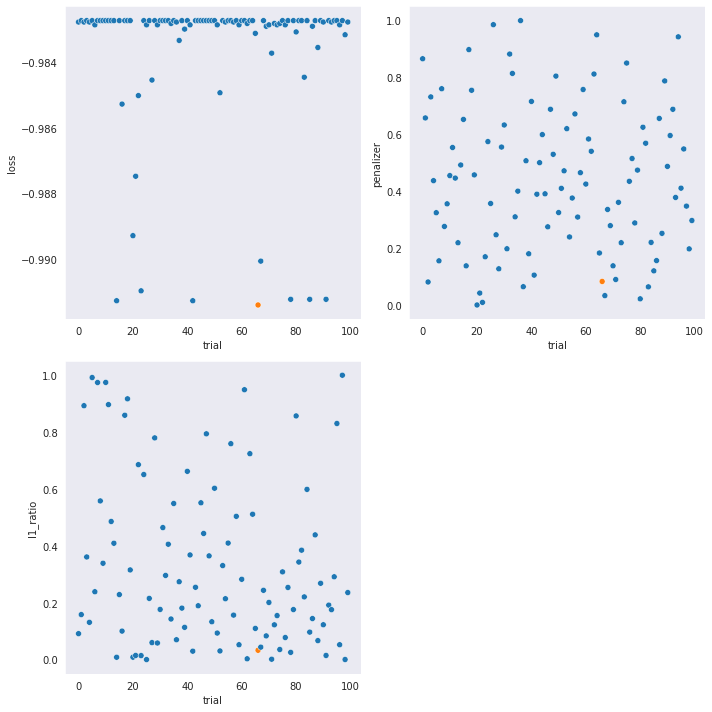

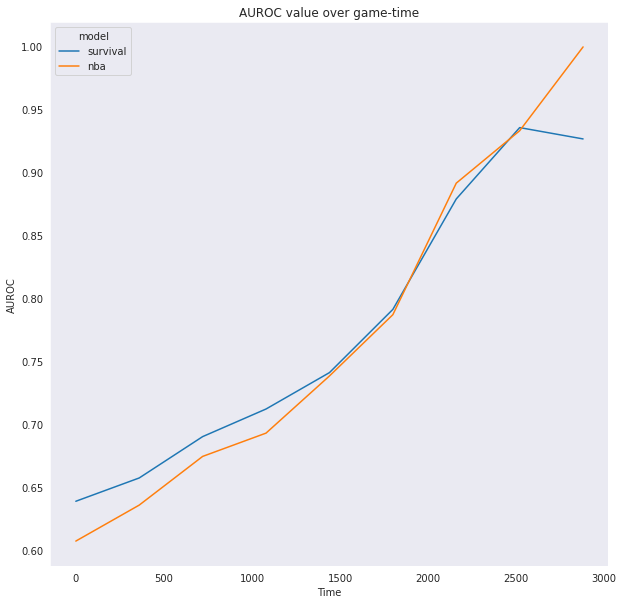

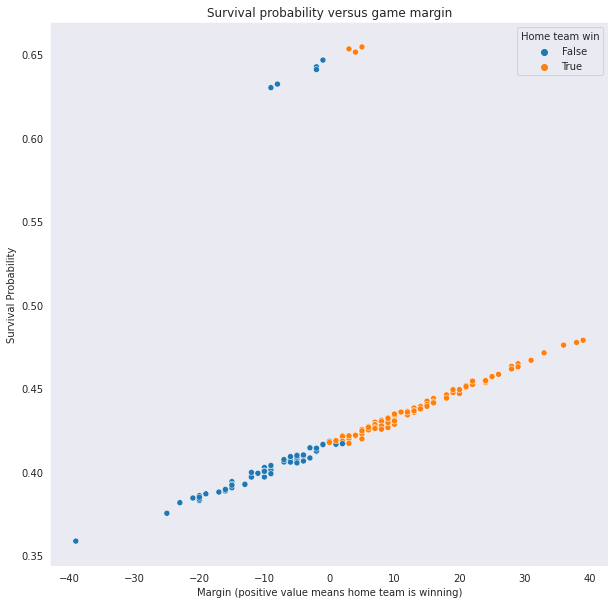

In [6]:
output = flow.run()